In [41]:
import requests
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 10)

In [42]:
FRED_API_KEY = "a8837523b7c200b627e6e1f1a7275566"
SERIES_ID = "DGS1"
START_DATE = "2020-01-01"
END_DATE   = "2024-12-31"

def fetch_fred_series(series_id, start_date, end_date, api_key):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    
    obs = data["observations"]
    dates = [o["date"] for o in obs]
    values = []
    for o in obs:
        v = o["value"]
        # FRED uses "." to denote missing values
        if v == ".":
            values.append(np.nan)
        else:
            values.append(float(v))
    
    df = pd.DataFrame({"date": pd.to_datetime(dates), "rate_pct": values})
    df.set_index("date", inplace=True)
    return df

rates_raw = fetch_fred_series(SERIES_ID, START_DATE, END_DATE, FRED_API_KEY)

rates_raw.head(), rates_raw.tail()


(            rate_pct
 date                
 2020-01-01       NaN
 2020-01-02      1.56
 2020-01-03      1.55
 2020-01-06      1.54
 2020-01-07      1.53,
             rate_pct
 date                
 2024-12-25       NaN
 2024-12-26      4.23
 2024-12-27      4.20
 2024-12-30      4.17
 2024-12-31      4.16)

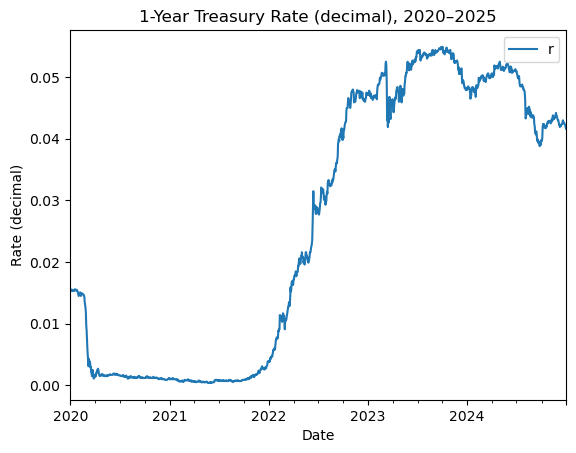

,r
date,
2020-01-01,0.0156
2020-01-02,0.0156
2020-01-03,0.0155
2020-01-06,0.0154
2020-01-07,0.0153


In [43]:
rates = rates_raw.copy()
rates["rate_pct"] = rates["rate_pct"].astype(float)
rates["rate_pct"] = rates["rate_pct"].interpolate(limit_direction="both")


rates["r"] = rates["rate_pct"] / 100.0


rates = rates[["r"]]

rates.plot(title="1-Year Treasury Rate (decimal), 2020–2025")
plt.xlabel("Date")
plt.ylabel("Rate (decimal)")
plt.show()

rates.head()

In [44]:
r_series = rates["r"].dropna()
r_t   = r_series.shift(1).dropna()
r_tp1 = r_series.loc[r_t.index]

df_reg = pd.DataFrame({"r_t": r_t, "r_tp1": r_tp1}).dropna()


delta = 1.0 / 252.0

X = sm.add_constant(df_reg["r_t"])
y = df_reg["r_tp1"]

model = sm.OLS(y, X).fit()
alpha = model.params["const"]
beta  = model.params["r_t"]
s2    = model.mse_resid

alpha, beta, s2, model.rsquared

(np.float64(2.42340105427829e-05),
 np.float64(0.9998353092243837),
 np.float64(2.59826788555211e-07),
 np.float64(0.9994640411576106))

In [45]:
phi = beta
if not (0 < phi < 1):
    print("Warning: phi is not in (0,1); Vasicek interpretation may be problematic.")

b = alpha / (1 - phi)
a = -np.log(phi) / delta
sigma2 = s2 * 2 * a / ((1 - phi**2) * delta)
sigma = np.sqrt(sigma2)

print("Estimated Vasicek parameters:")
print(f"a (speed of mean reversion): {a:.4f}")
print(f"b (long-run mean)         : {b:.4%} (decimal)")
print(f"sigma (vol of short rate) : {sigma:.4%} (per sqrt(year))")
print(f"AR(1) R^2                 : {model.rsquared:.4f}")

Estimated Vasicek parameters:
a (speed of mean reversion): 0.0415
b (long-run mean)         : 14.7149% (decimal)
sigma (vol of short rate) : 12.8463% (per sqrt(year))
AR(1) R^2                 : 0.9995


In [46]:
r0 = r_series.iloc[-1]
T_horizon = 0.25

m_T = b + (r0 - b) * np.exp(-a * T_horizon)
v_T = sigma**2 / (2 * a) * (1 - np.exp(-2 * a * T_horizon))
std_T = np.sqrt(v_T)

print(f"Last observed r_0 (end of 2024): {r0:.4%}")
print(f"Mean of r_T (1 quarter ahead)     : {m_T:.4%}")
print(f"Std dev of r_T                : {std_T:.4%}")

Last observed r_0 (end of 2024): 4.1600%
Mean of r_T (1 quarter ahead)     : 4.2690%
Std dev of r_T                : 6.3900%


In [47]:
n_sims = 100_000
rng = np.random.default_rng(seed=42)
r_T_samples = rng.normal(loc=m_T, scale=std_T, size=n_sims)

quantiles = np.quantile(r_T_samples, [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
quantiles_series = pd.Series(
    quantiles,
    index=["1%", "5%", "25%", "50%", "75%", "95%", "99%"]
)

print("Predictive distribution for r_T (end of 2026), in %:")
print((quantiles_series * 100).round(3))

Predictive distribution for r_T (end of 2026), in %:
1%    -10.706
5%     -6.328
25%    -0.067
50%     4.211
75%     8.548
95%    14.790
99%    19.242
dtype: float64


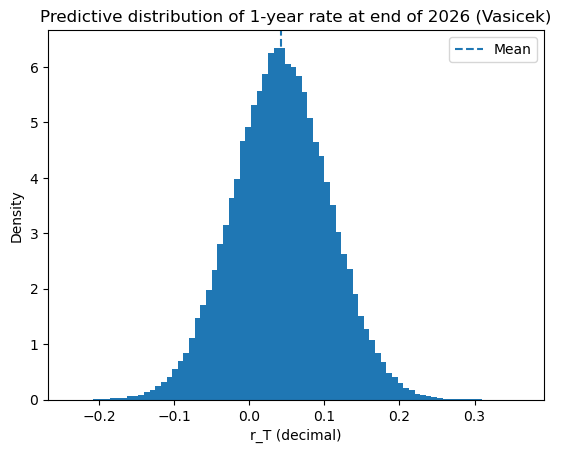

In [48]:
plt.hist(r_T_samples, bins=80, density=True)
plt.axvline(m_T, linestyle="--", label="Mean")
plt.title("Predictive distribution of 1-year rate at end of 2026 (Vasicek)")
plt.xlabel("r_T (decimal)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [49]:
def simulate_vasicek_paths(r0, a, b, sigma, T, n_steps, n_paths, seed=123):
    dt = T / n_steps
    rng = np.random.default_rng(seed=seed)
    r_paths = np.zeros((n_steps + 1, n_paths))
    r_paths[0, :] = r0
    
    for t in range(1, n_steps + 1):
        z = rng.standard_normal(size=n_paths)
        r_prev = r_paths[t - 1, :]
        # Euler step
        dr = a * (b - r_prev) * dt + sigma * np.sqrt(dt) * z
        r_paths[t, :] = r_prev + dr
    
    return r_paths


n_steps_2026 = 252
n_paths_2026 = 20_000

r_paths_2026 = simulate_vasicek_paths(
    r0=r0, a=a, b=b, sigma=sigma, 
    T=1.0, n_steps=n_steps_2026, n_paths=n_paths_2026, seed=123
)

r_paths_2026.shape

(253, 20000)

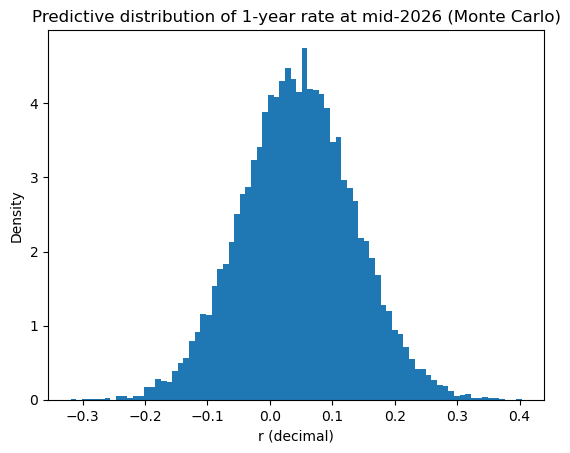

5%    -10.338936
50%     4.506436
95%    19.419766
dtype: float64

In [50]:
mid_index = n_steps_2026 // 2
mid_samples = r_paths_2026[mid_index, :]

plt.hist(mid_samples, bins=80, density=True)
plt.title("Predictive distribution of 1-year rate at mid-2026 (Monte Carlo)")
plt.xlabel("r (decimal)")
plt.ylabel("Density")
plt.show()

pd.Series(np.quantile(mid_samples, [0.05, 0.5, 0.95]), index=["5%", "50%", "95%"]) * 100

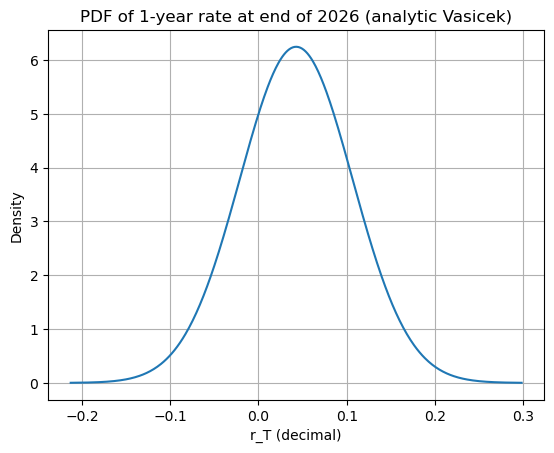

In [51]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

x_grid = np.linspace(m_T - 4*std_T, m_T + 4*std_T, 500)

pdf_grid = norm.pdf(x_grid, loc=m_T, scale=std_T)

plt.plot(x_grid, pdf_grid)
plt.title("PDF of 1-year rate at end of 2026 (analytic Vasicek)")
plt.xlabel("r_T (decimal)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

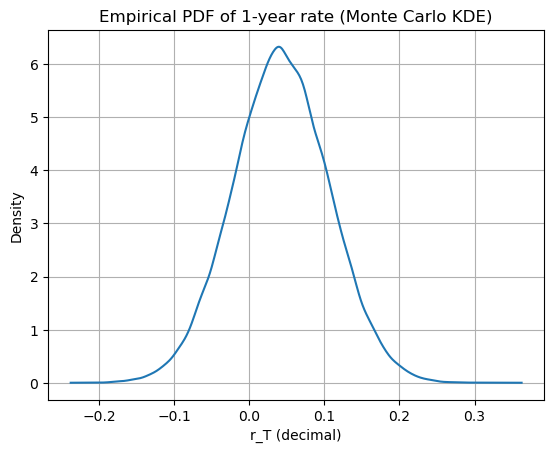

In [52]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

kde = gaussian_kde(r_T_samples)

x_grid_emp = np.linspace(min(r_T_samples), max(r_T_samples), 500)
pdf_emp = kde(x_grid_emp)

plt.plot(x_grid_emp, pdf_emp)
plt.title("Empirical PDF of 1-year rate (Monte Carlo KDE)")
plt.xlabel("r_T (decimal)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [53]:
print(a)
print(b)
print(sigma)
print(r0)

# all looks good

0.04150549333507725
0.14714856039807236
0.1284630614528961
0.0416


In [54]:
kappa_hat = a
theta_hat = b
sigma_hat = sigma

In [55]:
import numpy as np
import pandas as pd

def simulate_vasicek_1y(kappa, theta, sigma, r0, T=1.0, n_paths=100000, random_state=None):
    """
    Simulate r_T for a 1-year horizon under Vasicek using the closed-form normal distribution.
    Returns a numpy array of shape (n_paths,).
    """
    rng = np.random.default_rng(random_state)
    

    exp_term = np.exp(-kappa * T)
    m_T = theta + (r0 - theta) * exp_term
    v_T = (sigma**2 / (2.0 * kappa)) * (1.0 - np.exp(-2.0 * kappa * T))
    
    r_T_samples = rng.normal(loc=m_T, scale=np.sqrt(v_T), size=n_paths)
    return r_T_samples

In [56]:
r_T_base = simulate_vasicek_1y(kappa_hat, theta_hat, sigma_hat, r0)

In [129]:
base_params = {
    "kappa": kappa_hat,
    "theta": theta_hat,
    "sigma": sigma_hat,
    "r0": r0,
}

scenarios = {

    "policy_regime_shift": {
        "delta_r0": 0.0,
        "delta_theta": 0.0,
        "sigma_mult": 1.3,
        "kappa_mult": 1.5,
    },

}

scenarios = {
    # 200 bps parallel upward shift in the curve (e.g. inflation / policy shock)
    "parallel_up_200bp": {
        "delta_r0": 0.05,    # +200 bps today
        "delta_theta": 0.05, # long-run level up by 200 bps
        "sigma_mult": 1.0,
        "kappa_mult": 1.0,
    },
    # Recession: lower rates, higher vol
    "recession": {
        "delta_r0": -0.01,   # -100 bps immediate cut
        "delta_theta": -0.01,
        "sigma_mult": 1.5,   # 50% more volatility
        "kappa_mult": 0.8,   # slower mean reversion
    },

    
    # Aggressive central bank: stronger mean reversion, higher vol
    "policy_regime_shift": {
        "delta_r0": 0.0,
        "delta_theta": 0.0,
        "sigma_mult": 1.3,
        "kappa_mult": 1.5,
    },
}

In [115]:
def run_stress_tests(base_params, scenarios, T=1.0, n_paths=100000, random_state=42):
    results = {}

    for name, shock in scenarios.items():
        kappa_s = base_params["kappa"] * shock.get("kappa_mult", 1.0)
        theta_s = base_params["theta"] + shock.get("delta_theta", 0.0)
        sigma_s = base_params["sigma"] * shock.get("sigma_mult", 1.0)
        r0_s    = base_params["r0"]    + shock.get("delta_r0", 0.0)

        r_T = simulate_vasicek_1y(
            kappa=kappa_s,
            theta=theta_s,
            sigma=sigma_s,
            r0=r0_s,
            T=T,
            n_paths=n_paths,
            random_state=random_state,
        )

        results[name] = {
            "samples": r_T,
            "mean": float(np.mean(r_T)),
            "std": float(np.std(r_T)),
            "p01": float(np.quantile(r_T, 0.01)),
            "p05": float(np.quantile(r_T, 0.05)),
            "p50": float(np.quantile(r_T, 0.50)),
            "p95": float(np.quantile(r_T, 0.95)),
            "p99": float(np.quantile(r_T, 0.99)),
        }
    return results

stress_results = run_stress_tests(base_params, scenarios)

In [128]:
base_stats = {
    "mean": float(np.mean(r_T_base)),
    "std": float(np.std(r_T_base)),
    "p01": float(np.quantile(r_T_base, 0.01)),
    "p05": float(np.quantile(r_T_base, 0.05)),
    "p50": float(np.quantile(r_T_base, 0.50)),
    "p95": float(np.quantile(r_T_base, 0.95)),
    "p99": float(np.quantile(r_T_base, 0.99)),
}
pd.DataFrame.from_dict({"baseline": base_stats} | stress_results, orient="index")

,mean,std,p01,p05,p50,p95,p99,samples
baseline,0.046637,0.125707,-0.246167,-0.159947,0.046545,0.252861,0.338792,NaN
policy_regime_shift,0.047285,0.162535,-0.331527,-0.220575,0.046513,0.314597,0.427425,"[0.09731547174140606, -0.12043969328582937, 0...."


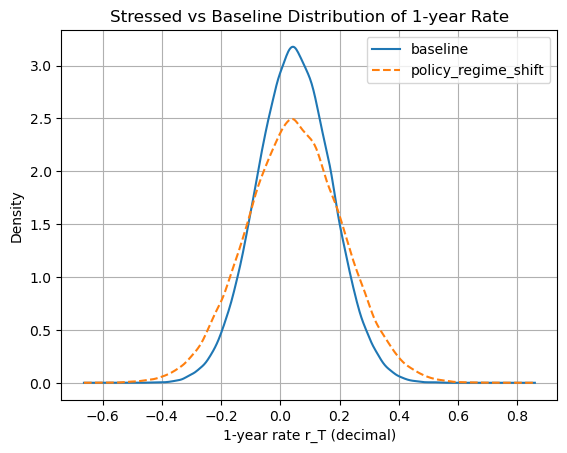

In [127]:
kde_base = gaussian_kde(r_T_base)
x_grid = np.linspace(
    min(np.min(r_T_base), *(np.min(v["samples"]) for v in stress_results.values())),
    max(np.max(r_T_base), *(np.max(v["samples"]) for v in stress_results.values())),
    500,
)
plt.plot(x_grid, kde_base(x_grid), label="baseline")

for name, res in stress_results.items():
    kde_s = gaussian_kde(res["samples"])
    plt.plot(x_grid, kde_s(x_grid), linestyle="--", label=name)

plt.xlabel("1-year rate r_T (decimal)")
plt.ylabel("Density")
plt.title("Stressed vs Baseline Distribution of 1-year Rate")
plt.grid(True)
plt.legend()
plt.show()

In [70]:
r_terminal = r_T_samples

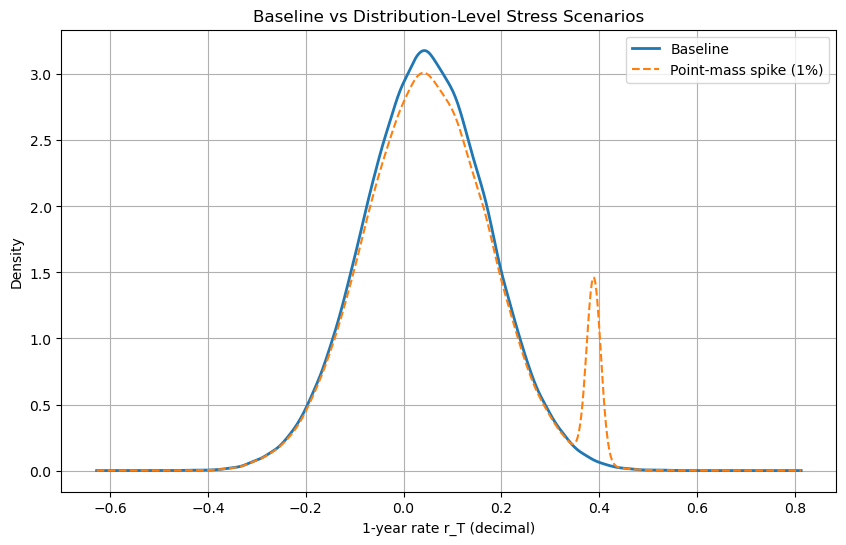

In [125]:
def add_point_mass_spike(r_T, p=0.01, r_star=0.12, jitter=5e-4, seed=0):
    rng = np.random.default_rng(seed)
    r = np.asarray(r_T)
    mask = rng.uniform(size=r.shape[0]) < p
    r_spiked = r.copy()
    r_spiked[mask] = r_star + rng.normal(0, jitter, size=mask.sum())
    return r_spiked, mask


r_star = np.quantile(r_T_base, 0.99) + 0.05 #Where the mass appears 

r_T_point, mask_point = add_point_mass_spike(
    r_T_base,
    p=0.05, #Change this too
    r_star=r_star,
    seed=2
)


from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))


kde_base = gaussian_kde(r_T_base)
x_grid = np.linspace(
    min(r_T_base.min(), r_T_mixture.min(), r_T_point.min()),
    max(r_T_base.max(), r_T_mixture.max(), r_T_point.max()),
    600,
)
plt.plot(x_grid, kde_base(x_grid), label="Baseline", linewidth=2)



kde_point = gaussian_kde(r_T_point)
plt.plot(x_grid, kde_point(x_grid), linestyle="--", label="Point-mass spike (5%)")


plt.xlabel("1-year rate r_T (decimal)")
plt.ylabel("Density")
plt.title("Baseline vs Distribution-Level Stress Scenarios")
plt.grid(True)
plt.legend()
plt.show()